### `Survey` Tutorial

This tutorial introduces reader to `Survey` class, a lightweight wrapper which provides access to SEG-Y trace headers and means to load various seismic gathers. <br>
The notebook leads through `Survey` initialization and highlights its most useful attributes and methods. <br>

### Table Of Contents

[SEG-Y format](#SEG-Y-format) <br>
[Introduction](#Introduction) <br>
[Attributes](#Attributes) <br>
[Methods](#Methods) <br>
[Creating Gather](#Creating-Gather) <br>
[Conclusion](#Conclusion) <br>

In [1]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt

from seismicpro import Survey, make_prestack_segy
from utils import generate_trace

### SEG-Y format

`Survey`  is a concise image of a SEG-Y file, so it is useful to brush up on the file's format. Scheme below shows SEG-Y format of revision 2:

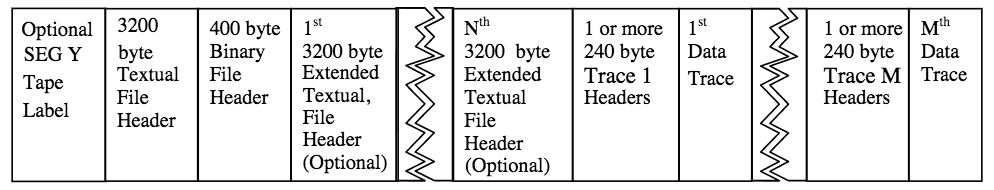

 It consists of three main blocks:<br>
- File Header with general information about the seismic survey.
- Trace Headers that contain metadata about each trace.
- Trace Data with recorded signal.

`Survey` stores a part of general data from File Header and specific fields from Trace Headers for each trace. It does not store any Trace Data, but can load it and put in a generated instance of [`Gather`](TODO) class. This allows keeping memory footprint of `Survey` to a minimum.

### Introduction

For convenience, this tutorial uses SEG-Y file with synthetic data that is going to be generated in the following cell.

In [2]:
sgy_path = './synthetic_survey.sgy'
make_prestack_segy(sgy_path, survey_size=(1500,1500), activation_dist=(1500,1500), trace_gen=generate_trace)

Common shot gathers generated:   0%|          | 0/150 [00:00<?, ?it/s]

To create a `Survey` object one needs to provide a path to the SEG-Y file and specify trace headers to load:

In [3]:
survey = Survey(sgy_path, header_index='FieldRecord', header_cols='offset')

Trace headers loaded:   0%|          | 0/135000 [00:00<?, ?it/s]

`Survey` object stores loaded trace headers as `pandas.DataFrame` named `headers`. <br>

`header_index` is a name of a trace header or a list of trace header names that is going to be used as an index of the `headers` DataFrame. Its value is also used to group traces to obtain and load seismic gathers.<br>`header_cols` can be a string or a list of strings with other trace headers one needs to load.<br>
All available trace headers are listed in [Trace headers keys](https://segyio.readthedocs.io/en/latest/segyio.html#trace-header-keys) section of `segyio` library documentation.<br>

To see summary about the SEG-Y file, one can call `info()` method of the initialized object: <br>

In [4]:
survey.info()

Survey path:               /notebooks/dpodvyaznikov/SeismicPro/tutorials/synthetic_survey.sgy
Survey name:               synthetic_survey
Survey size:               0.785 GB

Indexed by:                FieldRecord
Number of gathers:         150
Number of traces:          135000
Trace length:              1500 samples
Sample rate:               2.0 ms
Times range:               [0.0 ms, 2998.0 ms]
Offsets range:             [0 m, 2068 m]


In this example `survey` is indexed with `'FieldRecord'` trace header - the one that describes energy sources. Since `Survey` groups traces into gathers by the common value of `header_index`, `survey` will generate common shot gathers. See a table that lists gather types and corresponding values for `header_index` below:

| Gather type | header_index |
| :- | -: |
| Common-shot gather | `'FieldRecord'` |
| Common-midpoint gather | `'CDP'` / `['INLINE_3D', 'CROSSLINE_3D']`|
| Common-receiver gather | `['GroupX', 'GroupY']` |
| Common-offset section | `'offset'` |

### Attributes

<b>`headers`</b> - `pandas.DataFrame` containing the trace headers specified at the instantiation of `Survey` object. <br>

In [5]:
survey.headers

,offset,TRACE_SEQUENCE_FILE
FieldRecord,,
0,0,1
0,25,2
0,50,3
0,75,4
0,100,5
...,...,...
149,182,134996
149,206,134997
149,230,134998


<b>`sample_rate` </b> - sample interval for each trace in milliseconds

In [6]:
survey.sample_rate

2.0

<b>`samples`</b> or <b>`times`</b> - array of record timestamps in milliseconds<br>
An array that usually starts at 0 and increments by `sample_rate`.

In [7]:
survey.samples

array([0.000e+00, 2.000e+00, 4.000e+00, ..., 2.994e+03, 2.996e+03,
       2.998e+03], dtype=float32)

In [8]:
survey.times

array([0.000e+00, 2.000e+00, 4.000e+00, ..., 2.994e+03, 2.996e+03,
       2.998e+03], dtype=float32)

<b>`n_samples`</b> - number of record timestamps<br>
This is a shortcut for `len(self.samples)`.

In [9]:
survey.n_samples

1500

<b>`n_traces`</b> - number of traces in the survey<br>

In [10]:
survey.n_traces

135000

<b>`n_gathers`</b> - number of gathers in the survey<br>
In our case `survey` contains 150 common shot gathers.

In [11]:
survey.n_gathers

150

### Methods

<b>`filter()` </b>

This method returns a new `Survey` object with a subset of original traces that satisfy given condition.

`Survey.filter` expects a condition given as a callable and names of columns from `headers` which will be passed to the condition. <br>
This example shows how to select traces with `offset` less than 100 meters:

In [12]:
filtered_survey = survey.filter(cond=lambda x: x < 100, cols='offset')
filtered_survey.info()

Survey path:               /notebooks/dpodvyaznikov/SeismicPro/tutorials/synthetic_survey.sgy
Survey name:               synthetic_survey
Survey size:               0.785 GB

Indexed by:                FieldRecord
Number of gathers:         150
Number of traces:          1408
Trace length:              1500 samples
Sample rate:               2.0 ms
Times range:               [0.0 ms, 2998.0 ms]
Offsets range:             [0 m, 90 m]


Resulting `filtered_survey` contains less traces than the original one, and their offsets are all less than 100 m.

<b>`apply()` </b>

It applies a function to `headers` values.

`Survey.apply` expects a callable and names of columns from `headers` to apply callable to. <br>
In example below offset is doubled and the result is stored in a new `'offset_x2'` column. <br>

In [13]:
applied_survey = survey.apply(func=lambda x: x * 2, cols='offset', res_cols='offset_x2')
applied_survey.headers

,offset,TRACE_SEQUENCE_FILE,offset_x2
FieldRecord,,,
0,0,1,0
0,25,2,50
0,50,3,100
0,75,4,150
0,100,5,200
...,...,...,...
149,182,134996,364
149,206,134997,412
149,230,134998,460


<b>`mark_dead_traces()`</b>

`mark_dead_traces` iterates over traces and sets a value of a new `DeadTrace` header to `True` for traces with constant amplitudes. The overall number of dead traces is stored in the `n_dead_traces` attribute.

In [14]:
survey.mark_dead_traces()

Detecting dead traces for survey synthetic_survey:   0%|          | 0/135000 [00:00<?, ?it/s]

In [15]:
survey.info()

Survey path:               /notebooks/dpodvyaznikov/SeismicPro/tutorials/synthetic_survey.sgy
Survey name:               synthetic_survey
Survey size:               0.785 GB

Indexed by:                FieldRecord
Number of gathers:         150
Number of traces:          135000
Trace length:              1500 samples
Sample rate:               2.0 ms
Times range:               [0.0 ms, 2998.0 ms]
Offsets range:             [0 m, 2068 m]

Number of dead traces:     0


<b>`collect_stats()`</b>

`collect_stats` is used to calculate the traces' statistics and store this information in `Survey`. If `mark_dead_traces` method hasn't been called before, a warning is raised, since dead traces can skew amplitude data statistics.

In [16]:
survey.collect_stats()

Calculating statistics for survey synthetic_survey:   0%|          | 0/135000 [00:00<?, ?it/s]

In [17]:
survey.info()

Survey path:               /notebooks/dpodvyaznikov/SeismicPro/tutorials/synthetic_survey.sgy
Survey name:               synthetic_survey
Survey size:               0.785 GB

Indexed by:                FieldRecord
Number of gathers:         150
Number of traces:          135000
Trace length:              1500 samples
Sample rate:               2.0 ms
Times range:               [0.0 ms, 2998.0 ms]
Offsets range:             [0 m, 2068 m]

Survey statistics:
mean | std:                      0.01 | 0.63      
 min | max:                     -9.83 | 6.60      
 q01 | q99:                     -1.59 | 1.90      

Number of dead traces:     0


Now `survey.info()` has a new `Survey statistics` block.

These statistics allow performing normalization and standardization of the data, which is quite useful for many machine learning tasks.<br>

In case one trains a model not on the whole trace, but on the amplitudes in a specific time window, normalization/standardization should be carried out using statistics calculated in that exact time window.<br>
`Survey` provides this option via `limits` parameter, measured in samples, in `collect_stats()` method:
```python
survey_with_limits = survey.collect_stats(limits=(0,1000))
```

### Creating Gather

`Survey` objects do not store seismic data, but they have two methods that allow one to generate `Gather` objects with trace data: `sample_gather` and `get_gather`.

<b>`get_gather()`</b>

`get_gather` expects an index value from `header_index` and returns a `Gather` object with all the traces with this index value:<br>
```python
gather = survey.get_gather(some_index)
```

<b>`sample_gather()`</b>

`sample_gather` does the same, but it randomly selects an index value from `header_index`. <br>

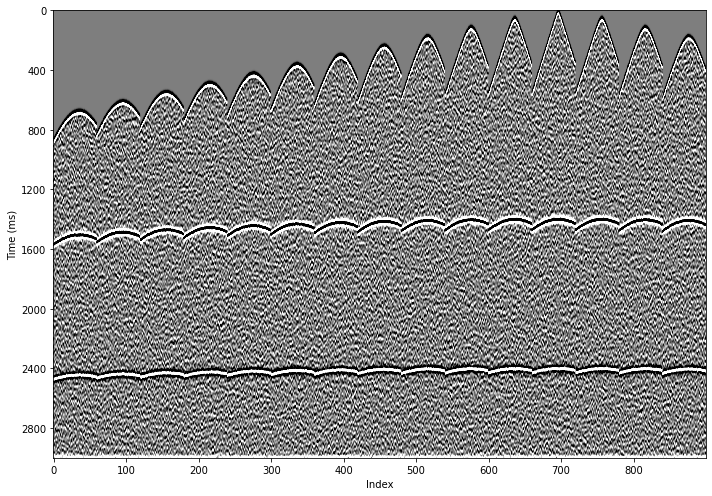

In [18]:
gather = survey.sample_gather()
gather.plot()

Read more about `Gather` in [this tutorial](./2_Gather.ipynb).

### Conclusion

This tutorial
* explained the purpose of `Survey` class and showed a process of its instantiation
* described `Survey`'s principal attributes with examples of their contents
* listed `Survey`'s most important methods with illustrations of their calls

[Go to top](#Survey-Tutorial)